In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from IPython.display import clear_output

In [3]:
def image_loader(image_name, imsize=512):
    image = Image.open(image_name)
    
    preprocess = transforms.Compose([transforms.Resize((imsize, imsize)),
                                     transforms.ToTensor()
                                    ])
    
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float)

In [4]:
def get_image_from_tensor(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    return image
        
def imshow(tensors, title=None, row_images=False):
    plt.figure(figsize=(18, 6))
    if isinstance(tensors, list):
        for i, tensor in enumerate(tensors):
            image = get_image_from_tensor(tensor)
            plt.subplot(1, len(tensors), i+1)
            plt.imshow(image)
    else:
        image = get_image_from_tensor(tensors)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)
    plt.show()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_size = 128
if device == "cuda":
    img_size = 512
device

device(type='cuda')

In [6]:
def gram_matrix(inp):
    (b, ch, h, w) = inp.size()
    features = inp.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = torch.bmm(features, features_t) / (ch * h * w)
    return gram


class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input_img):
        self.loss = F.mse_loss(input_img, self.target)
        return input_img

    
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input_img):
        G = gram_matrix(input_img)
        self.loss = F.mse_loss(G, self.target)
        return input_img


class Normalization(nn.Module):
    """normalize img"""
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [7]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [8]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
content_layers_default = ['conv_7', 'conv_8']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    content_losses = []
    style_losses = []

    normalization = Normalization(normalization_mean, normalization_std).to(device)
    model = nn.Sequential(normalization)
    max_content_layer = int(max([name.split('_')[1] for name in content_layers]))
    max_style_layer = int(max([name.split('_')[1] for name in style_layers]))
    max_stage = max(max_content_layer, max_style_layer)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)
        if i == max_stage:
            break

    return model, style_losses, content_losses


In [10]:
def style_transfer(model, optimizer, 
                       style_losses, content_losses,
                       input_img, n_epoch=15,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    
    for epoch in range(n_epoch):
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            
            style_score = 0
            content_score = 0
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()

            return style_score + content_score
        
        optimizer.step(closure)
        clear_output()
        print(f"* {epoch+1}/ {n_epoch} epoch")
        imshow(input_img)
    input_img.data.clamp_(0, 1)

    return input_img

In [11]:
def make_style_transfer(content_img_path, style_img_path, style_weight=1000000, n_epoch=4):
    style_img = image_loader('/content/drive/My Drive/hw/project/data/' + style_img_path, img_size)
    content_img = image_loader('/content/drive/My Drive/hw/project/data/' + content_img_path, img_size)
    optim_img = content_img.clone()

    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    style_model, texture_losses, content_losses = get_style_model_and_losses(cnn, 
                                               cnn_normalization_mean, cnn_normalization_std,
                                               style_img, content_img,
                                               content_layers=content_layers_default,
                                               style_layers=style_layers_default)


    optimizer = optim.LBFGS([optim_img.requires_grad_()])
    output = style_transfer(style_model, optimizer, texture_losses, content_losses, 
                            optim_img, n_epoch=n_epoch, content_weight=1, style_weight=style_weight)
    clear_output()
    imshow([content_img, style_img, output])
    return output

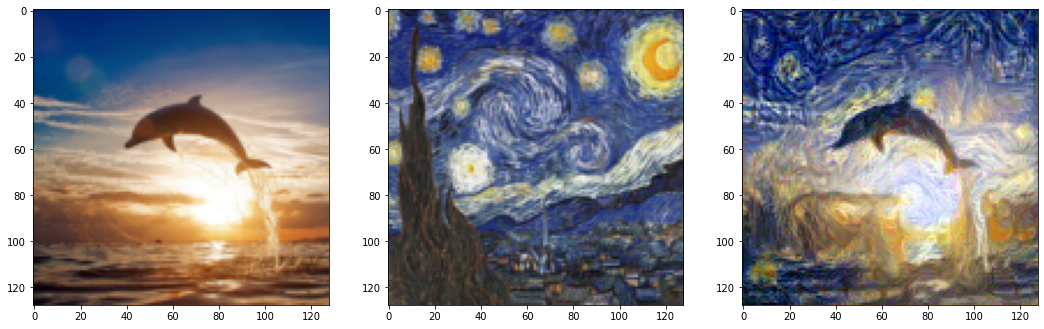

In [12]:
output_tensor = make_style_transfer('img0.jpg', 'style10.jpg',
                                    style_weight=100000000, n_epoch=3
                                    )

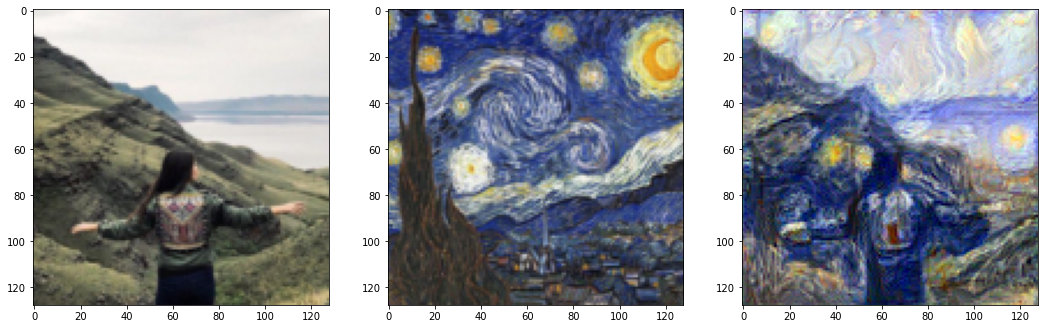

In [49]:
output_tensor = make_style_transfer('img4.jpg', 'style10.jpg',
                                    style_weight=100000000, n_epoch=7
                                    )

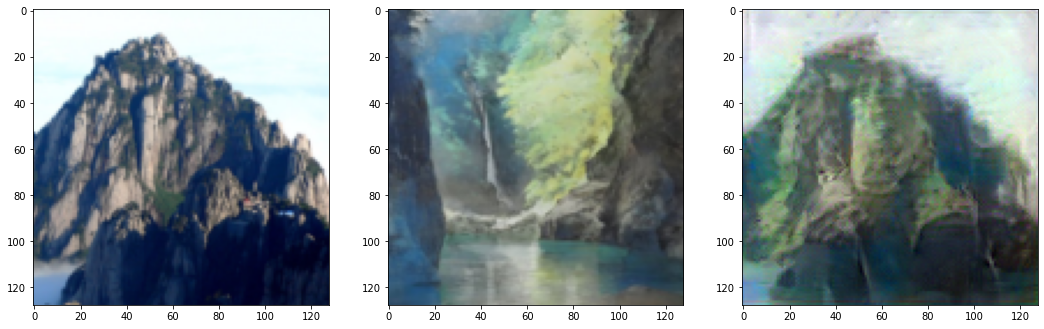

In [42]:
output_tensor = make_style_transfer('img2.jpg', 'style1.jpg',
                                    style_weight=10000000
                                    )

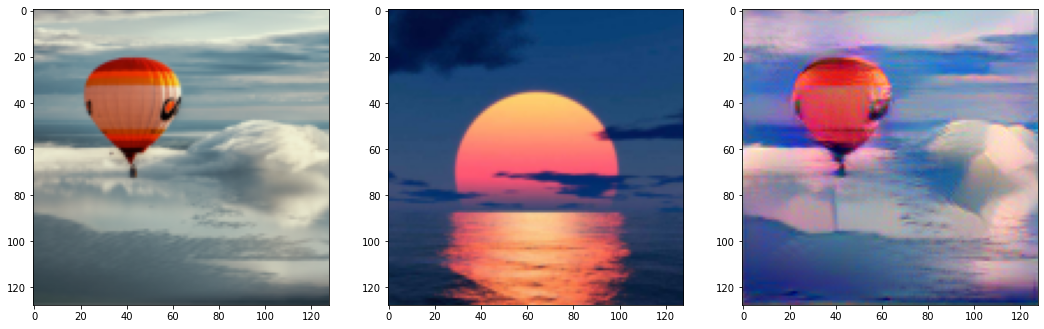

In [27]:
output_tensor = make_style_transfer('img5.jpg', 'style8.jpg',
                                    style_weight=1000000, n_epoch=4
                                    )

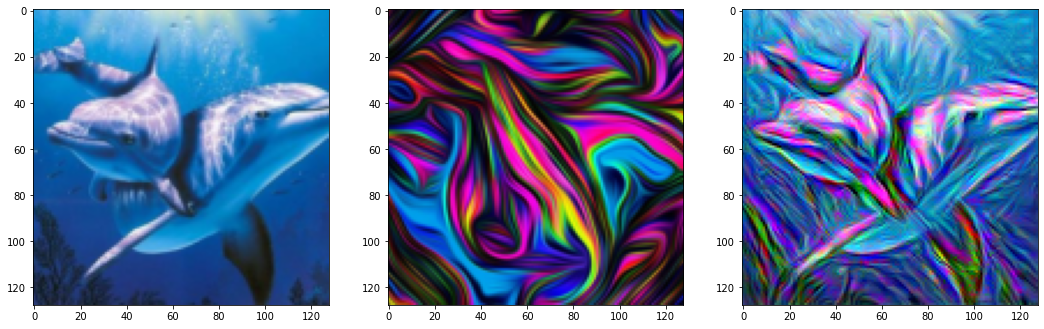

In [28]:
output_tensor = make_style_transfer('img7.jpg', 'style3.jpg',
                                    style_weight=10000, n_epoch=2
                                    )

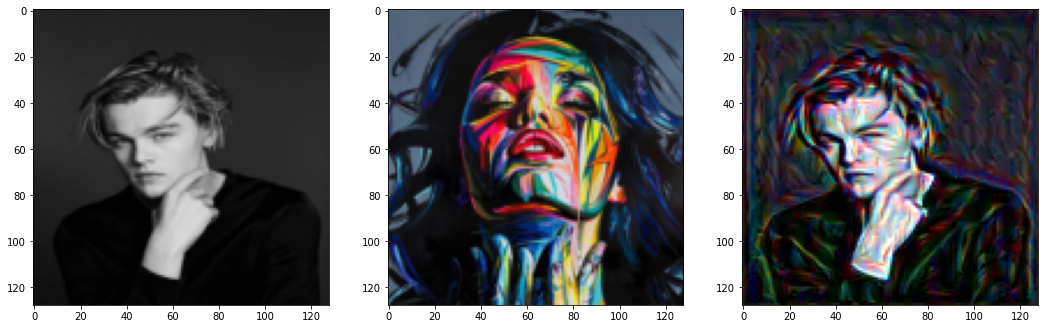

In [ ]:
output_tensor = make_style_transfer('img10.jpg', 'style7.jpg',
                                    style_weight=1000000, n_epoch=1
                                    )

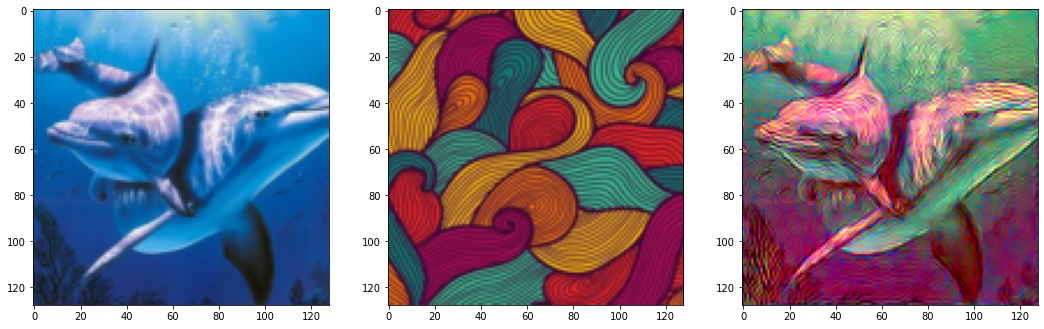

In [ ]:
output_tensor = make_style_transfer('img7.jpg', 'style5.jpg',
                                    style_weight=10000, n_epoch=2
                                    )

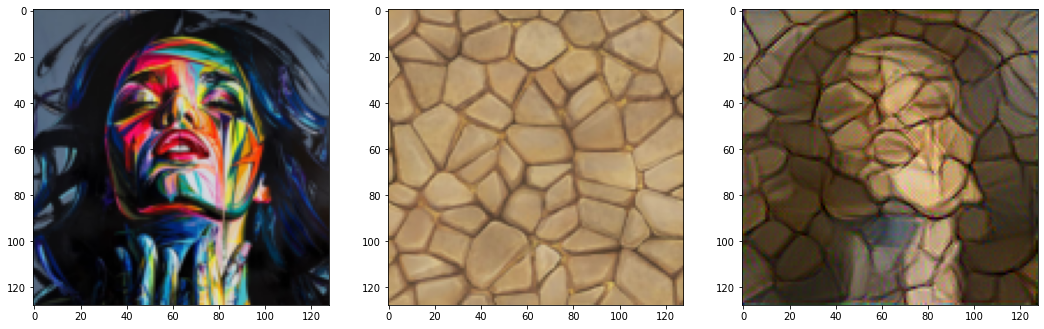

In [94]:
output_tensor = make_style_transfer('style7.jpg', 'style13.jpg',
                                    style_weight=10000000000, n_epoch=7
                                    )

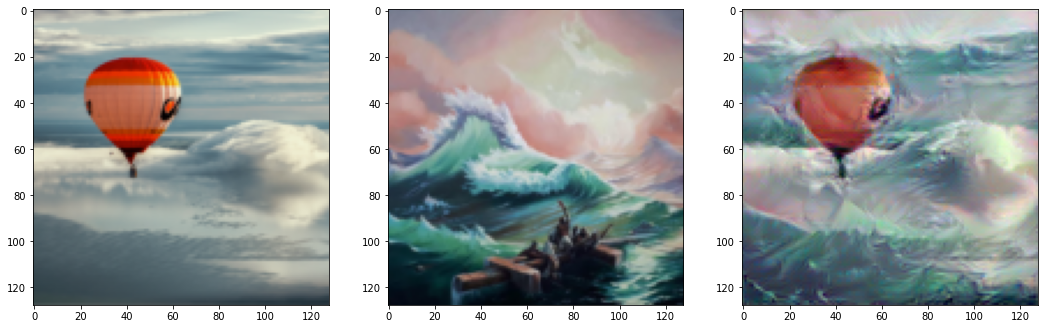

In [80]:
output_tensor = make_style_transfer('img5.jpg', 'img15.jpg',
                                    style_weight=1000000000, n_epoch=4
                                    )